# Model

In [1]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data - use Numpy for the processed versions since they were also saved with Numpy
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

## Linear Regression Fundamentals

Linear regression is the cornerstone of predictive modeling, representing relationships as straight lines in multi-dimensional space. Think of it as finding the "best-fit line" through a cloud of data points, but extended to handle multiple features simultaneously. The beauty lies in its simplicity: every prediction is just a weighted sum of your input features plus a constant term.

**Why It Matters:**

- **Interpretability**: Every coefficient tells a story about feature impact.
- **Speed**: Trains instantly even on large datasets.
- **Foundation**: Understanding linear regression unlocks advanced techniques.
- **Baseline**: Always start here before trying complex models.

Score: 0.119


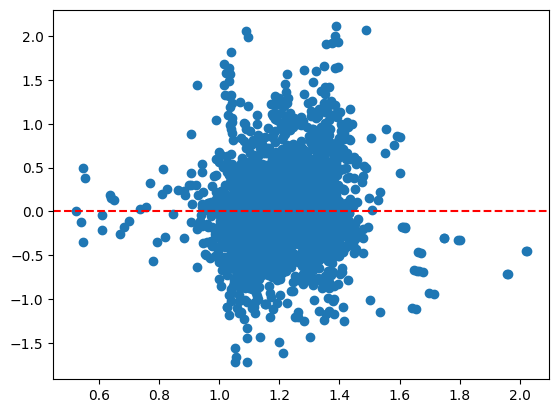

In [2]:
model = LinearRegression()

model.fit(X_train, y_train)

print(f"Score: {model.score(X_test, y_test):.3f}")

residuals = y_test - model.predict(X_test)

plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.show()

## Polynomial Regression: Modeling Curves in Your Data

💡 Concept: Polynomial regression fits curved relationships by introducing non-linear powers of features. It enables linear models to capture patterns that a straight line cannot, all while remaining computationally simple.

**Why It Matters**

- **Flexibility**: Models “U-shaped” or “n-shaped” data.
- **Interpretability**: Still linear in parameters, but non-linear in features.
- **Real-World Utility**: Many business processes (cost curves, diminishing returns) are not strictly linear.

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

print(X_train.columns)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train[['Food Transport']])
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

print(f"Score: {poly_model.score(poly.transform(X_test[['Food Transport']]), y_test):.3f}")

Index(['Year', 'Savanna fires', 'Forest fires', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Food Household Consumption', 'Food Retail', 'Food Packaging',
       'Food Processing', 'Fertilizers Manufacturing', 'IPPU',
       'Manure applied to Soils', 'Manure Management',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Urban population'],
      dtype='object')
Score: -0.861


## Ridge Regression - Gentle Coefficient Shrinkage

Ridge regression applies a smooth, proportional shrinkage to all coefficients. Imagine gradually turning down the volume on all features equally - none disappear completely, but their influence diminishes based on the regularization strength. This makes Ridge particularly effective when you believe all features contribute something valuable.

**Ridge Characteristics:**

- **Conservative approach**: Keeps all features in the model.
- **Handles multicollinearity**: Correlated features share the burden.
- **Smooth shrinkage**: Coefficients approach zero gradually.
- **Stable results**: Less sensitive to small data changes.

In [4]:
ridge = RidgeCV(alphas=[0.1, 1, 10])  # Auto-selects best alpha
ridge.fit(X_train, y_train)
print(f"Best alpha: {ridge.alpha_}")

grid = GridSearchCV(Ridge(), {'alpha': [0.1, 1, 10]}, cv=5)
grid.fit(X_train, y_train)
print(f"Best alpha: {grid.best_params_}")

Best alpha: 10.0
Best alpha: {'alpha': 10}


In [18]:
models = {'Linear': LinearRegression(), 'Ridge': RidgeCV(), 'Lasso': LassoCV()}
for name, model in models.items():
    score = cross_val_score(model, X_train, y_train['Average Temperature °C'], cv=5).mean()
    print(f"{name}: {score:.3f}")

Linear: 0.086
Ridge: 0.096
Lasso: 0.149


## Performance Metrics Deep Dive

Different metrics tell different stories about your model's performance. R² measures explanatory power, RMSE penalizes large errors more heavily, and MAE treats all errors equally. Understanding when to use each metric helps you evaluate models appropriately for your specific use case.

**Metric Characteristics:**

- R² (0-1): Proportion of variance explained; higher is better.
- RMSE: Root mean squared error; same units as target; penalizes outliers.
- MAE: Mean absolute error; robust to outliers; intuitive interpretation.

**Choosing the Right Metric:**

- R²: When you want to understand explanatory power.
- RMSE: When large errors are particularly costly.
- MAE: When all errors are equally important.

In [21]:
lasso_model = LassoCV(max_iter=10000)
lasso_model.fit(X_train, y_train['Average Temperature °C'])
y_pred = lasso_model.predict(X_test)

print(f"Score: {lasso_model.score(X_test, y_test):.3f}")

print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5:.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

Score: 0.092
R²: 0.092
RMSE: 0.508
MAE: 0.382


## Learning Curves for Model Diagnosis

Learning curves reveal your model's learning behavior as training data increases. They help diagnose whether you need more data, simpler models, or better features. Think of them as growth charts for your model - they show whether performance plateaus or continues improving with more examples.

**Curve Interpretation:**

- Converging curves at high performance: Good fit.
- Large gap between train/validation: Overfitting (high variance).
- Both curves plateau at low performance: Underfitting (high bias).
- Validation curve still improving: More data would help.

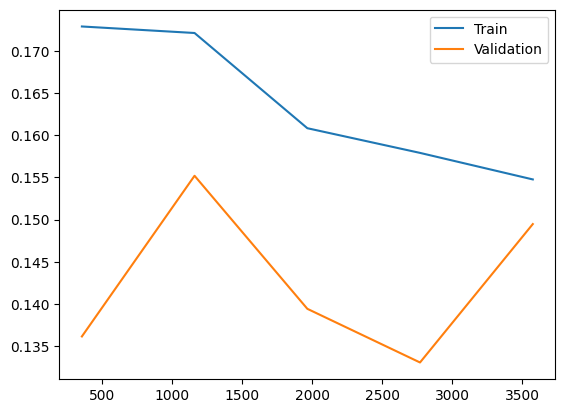

In [22]:
train_sizes, train_scores, val_scores = learning_curve(lasso_model, X_train, y_train['Average Temperature °C'], cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.legend()
plt.show()